# Transformer, Self-Attention и моделирование языка

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import youtokentome as yttm

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary, \
    save_texts_to_file, LanguageModelDataset, load_war_and_piece_chunks, \
    GreedyGenerator, BeamGenerator
from dlnlputils.pipeline import train_eval_loop, init_random_seed
from dlnlputils.base import get_params_number

init_random_seed()

## Загрузка текстов и разбиение на обучающую и тестовую подвыборки

In [3]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
all_chunks = load_war_and_piece_chunks('./datasets/war_and_peace.txt')
len(all_chunks)

7976

In [4]:
print(all_chunks[10])

у нее был грипп, как она говорила (грипп был тогда новое
слово, употреблявшееся только редкими). В записочках, разосланных утром с
красным лакеем, было написано без различия во всех:
  "Si vous n'avez


In [5]:
len(all_chunks[0])

200

In [6]:
print(all_chunks[-1])

 величие;



In [7]:
np.random.shuffle(all_chunks)

TRAIN_SPLIT = int(len(all_chunks) * 0.7)
train_texts = all_chunks[:TRAIN_SPLIT]
test_texts = all_chunks[TRAIN_SPLIT:]

print('Размер обучающей выборки', len(train_texts))
print('Размер валидационной выборки', len(test_texts))

Размер обучающей выборки 5583
Размер валидационной выборки 2393


## Токенизация корпуса с помощью BPE

BPE - Byte Pair Encoding

YouTokenToMe - быстрая реализация BPE

In [8]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
BPE_MODEL_FILENAME = './models/war_and_peace_bpe.yttm'

In [9]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
TRAIN_TEXTS_FILENAME = './datasets/war_and_peace_bpe_train.txt'
save_texts_to_file(train_texts, TRAIN_TEXTS_FILENAME)
yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=1000, model=BPE_MODEL_FILENAME);

In [10]:
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)

In [11]:
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ о а е и н т с л р в к , д м у п я г ь ы з б . ч й - ж ш e х ю s ц a n r i u o t щ э П l Н ф А В m d c О ? ! К Д Б p М v Р " ) С ( ' ; И Т ё 1 h : Я 2 q f Г ъ b g Ч Э 0 3 Е 5 ] [ j 4 I z Л З 6 8 M A 9 7 У Ж V L x X Ф Ш y C Х J B P D E N S k Ц R Q O T ` w Ю H U F G K Ь W Й * & # Щ Z / ▁с ▁п ▁в ▁н то ▁о ▁и ▁к го ал ра ст но ▁- ▁по ен ▁д ер ел ▁б ро ▁не ко во ка ▁ч ▁м ри ▁на ло ть на ли ла ▁з ▁е ▁у ▁т ре ва ни ся сь ак ▁что ру ет ▁ко ▁бы ми ны ня да ▁то ди хо ▁за ▁го ем ▁г ▁он ол ени ▁от ки ви ну каз е, ▁э та ▁П ти ши ▁при ▁вы ▁ра му ▁Н ▁ж ов ▁вс ле ▁А до ▁В ▁про ▁мо ля ▁как мо ▁во казал ры ▁его ма ▁об сто ▁это ль й, ▁сказал ере не ▁а ▁до ▁О ▁я ▁К ▁кото ▁сво ▁кня ▁Д м, у, ше ▁Б али по чи ▁но сти ▁ни си ча ста ель ▁из ве лу ала де ▁Ан вори ▁М ▁под ▁ка ▁d .. ша ... за ска жи ще es я, лся ▁со че лы зь сть ско ou ▁ли ▁хо ▁ви ▁ст ень ▁ру ря енно ▁Пь ▁так ме ты ▁p ▁Р ги га дел лю сно re же ▁раз ▁( со те ду ку ▁се ски ▁c ▁С ▁ва вши ▁все тель бе en вал ▁l ▁дру ▁было ▁И on

In [12]:
print(tokenizer.encode(train_texts[:1]))

[[210, 238, 244, 13, 317, 16, 147, 200, 12, 265, 35, 161, 337, 490, 203, 269, 447, 4, 111, 111, 96, 27, 415, 148, 176, 551, 201, 726, 199, 161, 848, 889, 772, 23, 16, 690, 179, 585, 18, 154, 412, 19, 382, 157, 186, 635, 10, 518, 774, 363, 670, 157, 793, 37, 7, 426, 791, 186, 635, 10, 518, 774, 650, 25, 988, 206, 186, 13, 201, 8, 149, 474, 17, 275, 31, 23, 8, 34, 444]]


In [13]:
train_token_ids = tokenizer.encode(train_texts, bos=True, eos=True)
test_token_ids = tokenizer.encode(test_texts, bos=True, eos=True)

In [14]:
train_token_ids[4]

[2,
 223,
 10,
 737,
 845,
 707,
 16,
 267,
 254,
 168,
 408,
 368,
 12,
 182,
 215,
 153,
 168,
 628,
 165,
 245,
 428,
 396,
 757,
 979,
 160,
 251,
 717,
 495,
 15,
 376,
 193,
 153,
 268,
 213,
 16,
 153,
 182,
 749,
 195,
 207,
 203,
 202,
 10,
 165,
 16,
 207,
 564,
 195,
 210,
 778,
 177,
 546,
 182,
 74,
 66,
 27,
 356,
 628,
 165,
 153,
 168,
 147,
 18,
 165,
 147,
 815,
 685,
 528,
 325,
 213,
 27,
 218,
 167,
 370,
 417,
 696,
 247,
 148,
 3]

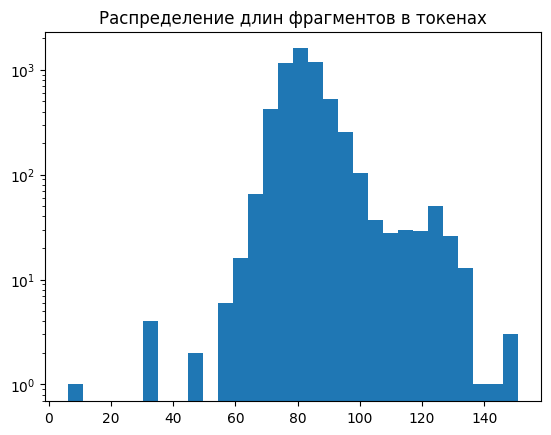

In [15]:
plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.yscale('log');

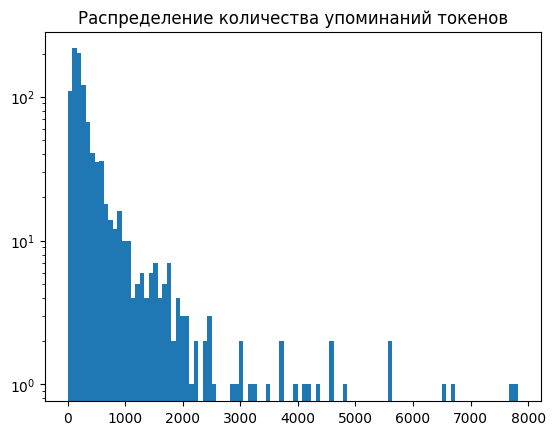

In [16]:
token_counts = np.bincount([token_id for text in train_token_ids for token_id in text])
plt.hist(token_counts, bins=100)
plt.title('Распределение количества упоминаний токенов')
plt.yscale('log');

In [17]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке',
      unknown_subwords_in_test)

Количество случаев с неизвестными n-граммами символов в валидационной выборке 0


## Подготовка датасетов для PyTorch

In [18]:
CHUNK_LENGTH = 80

train_dataset = LanguageModelDataset(train_token_ids,
                                     chunk_length=CHUNK_LENGTH)
test_dataset = LanguageModelDataset(test_token_ids,
                                    chunk_length=CHUNK_LENGTH)

In [19]:
train_dataset[0]

(array([  2, 210, 238, 244,  13, 317,  16, 147, 200,  12, 265,  35, 161,
        337, 490, 203, 269, 447,   4, 111, 111,  96,  27, 415, 148, 176,
        551, 201, 726, 199, 161, 848, 889, 772,  23,  16, 690, 179, 585,
         18, 154, 412,  19, 382, 157, 186, 635,  10, 518, 774, 363, 670,
        157, 793,  37,   7, 426, 791, 186, 635,  10, 518, 774, 650,  25,
        988, 206, 186,  13, 201,   8, 149, 474,  17, 275,  31,  23,   8,
         34, 444], dtype=int64),
 array([210, 238, 244,  13, 317,  16, 147, 200,  12, 265,  35, 161, 337,
        490, 203, 269, 447,   4, 111, 111,  96,  27, 415, 148, 176, 551,
        201, 726, 199, 161, 848, 889, 772,  23,  16, 690, 179, 585,  18,
        154, 412,  19, 382, 157, 186, 635,  10, 518, 774, 363, 670, 157,
        793,  37,   7, 426, 791, 186, 635,  10, 518, 774, 650,  25, 988,
        206, 186,  13, 201,   8, 149, 474,  17, 275,  31,  23,   8,  34,
        444,   3], dtype=int64))

In [20]:
len(train_dataset[0][0]), len(train_dataset[0][1]), len(train_dataset)

(80, 80, 5583)

In [21]:
print(len(train_token_ids[456]))
for i in range(2):
    print(train_dataset[456])

91
(array([180, 594,  31, 751, 160,   4, 117,  70, 434, 314, 612,  40,  16,
       695,  70, 434, 314, 612,  40,  58, 445,  88,  95, 160, 233, 262,
        20,  10, 277, 379,  16, 295, 961, 317, 492, 382,   8, 159, 626,
       281,  19,  31, 346, 410, 523, 175, 168,   7, 147, 311, 895, 304,
       231, 260, 236, 653, 207, 384, 183, 201,  14, 652,  16, 804, 193,
         8, 426, 191, 154, 151, 432, 182,  45, 215, 154, 167, 312, 241,
       153, 890], dtype=int64), array([594,  31, 751, 160,   4, 117,  70, 434, 314, 612,  40,  16, 695,
        70, 434, 314, 612,  40,  58, 445,  88,  95, 160, 233, 262,  20,
        10, 277, 379,  16, 295, 961, 317, 492, 382,   8, 159, 626, 281,
        19,  31, 346, 410, 523, 175, 168,   7, 147, 311, 895, 304, 231,
       260, 236, 653, 207, 384, 183, 201,  14, 652,  16, 804, 193,   8,
       426, 191, 154, 151, 432, 182,  45, 215, 154, 167, 312, 241, 153,
       890,  16], dtype=int64))
(array([160,   4, 117,  70, 434, 314, 612,  40,  16, 695,  70, 434, 

In [22]:
tokenizer.decode(list(train_dataset[0]))

['<BOS> от восторга, с толпою побежал за ним. XXI. На площади куда поехал государь, стояли лицом к лицу справа батальон преображенцев, слева батальон французской гвардии в медвежьих ш',
 'от восторга, с толпою побежал за ним. XXI. На площади куда поехал государь, стояли лицом к лицу справа батальон преображенцев, слева батальон французской гвардии в медвежьих ш<EOS>']

## Общие классы и функции

### Маска зависимостей

In [23]:
def make_target_dependency_mask(length):
    full_mask = torch.ones(length, length)
    ignore_mask = torch.tril(full_mask) < 1
    full_mask.masked_fill_(ignore_mask, float('-inf'))
    full_mask.masked_fill_(~ignore_mask, 0)
    return full_mask

make_target_dependency_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Кодирование позиции

In [24]:
def make_positional_encoding(max_length, embedding_size):
    time = np.pi * torch.arange(0, max_length).float()
    freq_dividers = torch.arange(1, embedding_size // 2 + 1).float()
    inputs = time[:, None] / freq_dividers[None, :]
    
    result = torch.zeros(max_length, embedding_size)
    result[:, 0::2] = torch.sin(inputs)
    result[:, 1::2] = torch.cos(inputs)
    return result

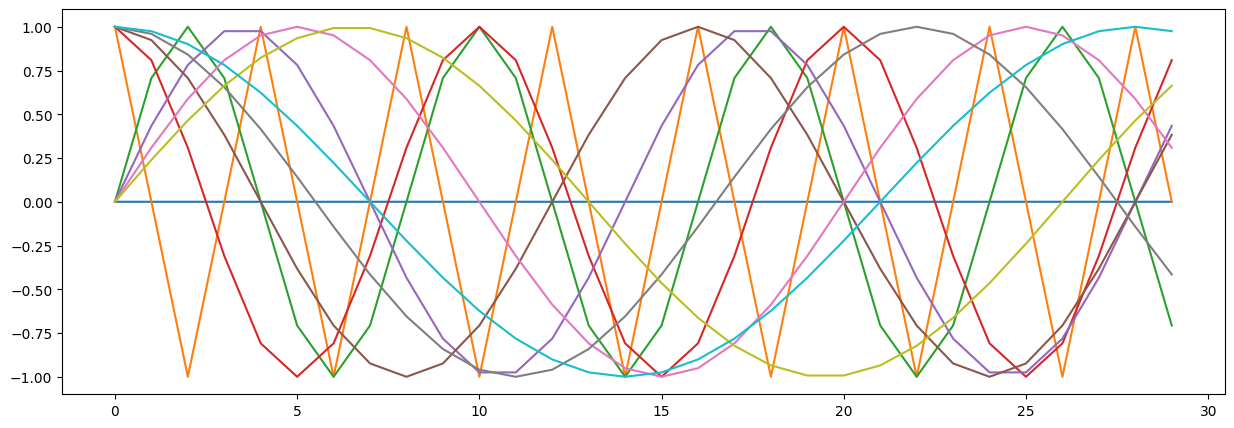

In [25]:
sample_pos_codes = make_positional_encoding(30, 30)
plt.plot(sample_pos_codes[:, ::3].numpy());
plt.gcf().set_size_inches((15, 5))

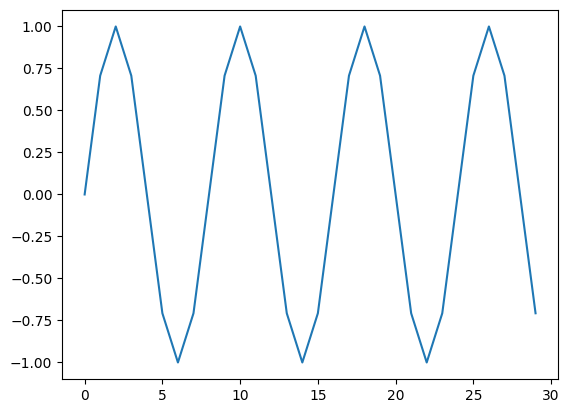

In [26]:
plt.plot(sample_pos_codes[:, 6])

### Основной класс - языковая модель

In [27]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, backbone, emb_dropout=0.0):
        super().__init__()
        self.embedding_size = embedding_size
        self.embeddings = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.backbone = backbone
        self.out = nn.Linear(embedding_size, vocab_size)
    
    def forward(self, seed_token_ids):
        """
            seed_token_ids - BatchSize x MaxInLen
        """
        batch_size, max_in_length = seed_token_ids.shape

        seed_padding_mask = seed_token_ids == 0
        dependency_mask = make_target_dependency_mask(max_in_length) \
            .to(seed_token_ids.device)
        
        seed_embs = self.embeddings(seed_token_ids)  # BatchSize x MaxInLen x EmbSize
        pos_codes = make_positional_encoding(max_in_length,
                                             self.embedding_size).unsqueeze(0).to(seed_embs.device)
        seed_embs = seed_embs + pos_codes
        seed_embs = self.emb_dropout(seed_embs)

        # BatchSize x TargetLen x EmbSize
        target_features = seed_embs
        target_features = self.backbone(seed_embs,
                                        mask=dependency_mask,
                                        src_key_padding_mask=seed_padding_mask)
        logits = self.out(target_features)  # BatchSize x TargetLen x VocabSize
        return logits

### Утилиты для обучения - функция потерь и расписание изменения длины градиентного шага

In [28]:
def lm_cross_entropy(pred, target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])  # BatchSize*TargetLen x VocabSize
    target_flat = target.view(-1)  # BatchSize*TargetLen
    return F.cross_entropy(pred_flat, target_flat, ignore_index=0)


def lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      patience=20,
                                                      factor=0.5,
                                                      verbose=True)

## Реализация Transformer из PyTorch 1.2

In [29]:
class BatchFirstTransformerEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.impl = nn.TransformerEncoder(*args, **kwargs)
        self.initialize_weights()
    
    def forward(self, src, *args, **kwargs):
        src = src.transpose(0, 1).contiguous()  # MaxInLen  x BatchSize x EmbSize
        result = self.impl(src, *args, **kwargs)  # TargetLen x BatchSize x EmbSize
        result = result.transpose(0, 1).contiguous()  # BatchSize x TargetLen x EmbSize
        return result
    
    def initialize_weights(self):
        for param in self.impl.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

In [30]:
torch_transf_model = LanguageModel(tokenizer.vocab_size(),
                                   256,
                                   BatchFirstTransformerEncoder(
                                       nn.TransformerEncoderLayer(
                                           d_model=256,
                                           nhead=16,
                                           dim_feedforward=512,
                                           dropout=0.1),
                                       num_layers=3),
                                   emb_dropout=0.1)
print('Количество параметров', get_params_number(torch_transf_model))

Количество параметров 2094312


In [31]:
(best_val_loss,
 best_torch_transf_model) = train_eval_loop(torch_transf_model,
                                            train_dataset,
                                            test_dataset,
                                            lm_cross_entropy,
                                            lr=2e-3,
                                            epoch_n=2000,
                                            batch_size=512,
                                            device='cuda',
                                            early_stopping_patience=50,
                                            max_batches_per_epoch_train=1000,
                                            max_batches_per_epoch_val=1000,
                                            lr_scheduler_ctor=lr_scheduler)

Эпоха 0
Эпоха: 11 итераций, 10.30 сек
Среднее значение функции потерь на обучении 6.4025420709089795
Среднее значение функции потерь на валидации 6.245659065246582
Новая лучшая модель!

Эпоха 1
Эпоха: 11 итераций, 2.08 сек
Среднее значение функции потерь на обучении 6.2404492551630195
Среднее значение функции потерь на валидации 6.2194116592407225
Новая лучшая модель!

Эпоха 2
Эпоха: 11 итераций, 2.08 сек
Среднее значение функции потерь на обучении 6.158939751711759
Среднее значение функции потерь на валидации 6.021595859527588
Новая лучшая модель!

Эпоха 3
Эпоха: 11 итераций, 2.08 сек
Среднее значение функции потерь на обучении 5.867680592970415
Среднее значение функции потерь на валидации 5.593539047241211
Новая лучшая модель!

Эпоха 4
Эпоха: 11 итераций, 2.08 сек
Среднее значение функции потерь на обучении 5.415460846640847
Среднее значение функции потерь на валидации 5.044164371490479
Новая лучшая модель!

Эпоха 5
Эпоха: 11 итераций, 2.08 сек
Среднее значение функции потерь на обуч

Среднее значение функции потерь на валидации 3.1976174831390383
Новая лучшая модель!

Эпоха 45
Эпоха: 11 итераций, 2.09 сек
Среднее значение функции потерь на обучении 2.7072331471876665
Среднее значение функции потерь на валидации 3.195488786697388
Новая лучшая модель!

Эпоха 46
Эпоха: 11 итераций, 2.09 сек
Среднее значение функции потерь на обучении 2.686783292076804
Среднее значение функции потерь на валидации 3.1879670143127443
Новая лучшая модель!

Эпоха 47
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 2.670321052724665
Среднее значение функции потерь на валидации 3.178635597229004
Новая лучшая модель!

Эпоха 48
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 2.649610497734763
Среднее значение функции потерь на валидации 3.1717676639556887
Новая лучшая модель!

Эпоха 49
Эпоха: 11 итераций, 2.09 сек
Среднее значение функции потерь на обучении 2.638571847568859
Среднее значение функции потерь на валидации 3.164650249481201
Новая лу

Среднее значение функции потерь на валидации 3.0105462074279785

Эпоха 90
Эпоха: 11 итераций, 2.09 сек
Среднее значение функции потерь на обучении 2.2093735824931753
Среднее значение функции потерь на валидации 3.0021759510040282
Новая лучшая модель!

Эпоха 91
Эпоха: 11 итераций, 2.14 сек
Среднее значение функции потерь на обучении 2.2023501179435034
Среднее значение функции потерь на валидации 2.997392702102661
Новая лучшая модель!

Эпоха 92
Эпоха: 11 итераций, 2.12 сек
Среднее значение функции потерь на обучении 2.194693001833829
Среднее значение функции потерь на валидации 2.996428871154785
Новая лучшая модель!

Эпоха 93
Эпоха: 11 итераций, 2.13 сек
Среднее значение функции потерь на обучении 2.1895101720636543
Среднее значение функции потерь на валидации 2.9926653861999513
Новая лучшая модель!

Эпоха 94
Эпоха: 11 итераций, 2.12 сек
Среднее значение функции потерь на обучении 2.1844768740914087
Среднее значение функции потерь на валидации 2.9887842655181887
Новая лучшая модель!

Эпо

Среднее значение функции потерь на валидации 2.9140200138092043

Эпоха 136
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.9847869656302712
Среднее значение функции потерь на валидации 2.9077481746673586

Эпоха 137
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.9790371439673684
Среднее значение функции потерь на валидации 2.9104096412658693

Эпоха 138
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.980158805847168
Среднее значение функции потерь на валидации 2.910546064376831

Эпоха 139
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.9729214364832097
Среднее значение функции потерь на валидации 2.898360824584961
Новая лучшая модель!

Эпоха 140
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.9664018479260532
Среднее значение функции потерь на валидации 2.90240797996521

Эпоха 141
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1

Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.8461479490453547
Среднее значение функции потерь на валидации 2.849899959564209

Эпоха 184
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.8511915315281262
Среднее значение функции потерь на валидации 2.8490331172943115

Эпоха 185
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.8465246504003352
Среднее значение функции потерь на валидации 2.8502532482147216

Эпоха 186
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.8449875441464512
Среднее значение функции потерь на валидации 2.844744348526001
Новая лучшая модель!

Эпоха 187
Эпоха: 11 итераций, 2.09 сек
Среднее значение функции потерь на обучении 1.8402660218152134
Среднее значение функции потерь на валидации 2.8446791648864744
Новая лучшая модель!

Эпоха 188
Эпоха: 11 итераций, 2.11 сек
Среднее значение функции потерь на обучении 1.839517972686074
Среднее значение функции потерь на

Эпоха: 11 итераций, 2.11 сек
Среднее значение функции потерь на обучении 1.763702555136247
Среднее значение функции потерь на валидации 2.8048680782318116

Эпоха 231
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.7567496408115735
Среднее значение функции потерь на валидации 2.808492136001587

Эпоха 232
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.7560893188823352
Среднее значение функции потерь на валидации 2.8022244930267335
Новая лучшая модель!

Эпоха 233
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.7543153762817383
Среднее значение функции потерь на валидации 2.8071854591369627

Эпоха 234
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.7529628710313276
Среднее значение функции потерь на валидации 2.80141282081604
Новая лучшая модель!

Эпоха 235
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.7493783235549927
Среднее значение функции потерь на 

Эпоха: 11 итераций, 2.09 сек
Среднее значение функции потерь на обучении 1.6886397491801868
Среднее значение функции потерь на валидации 2.77503662109375

Эпоха 279
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.6912420229478315
Среднее значение функции потерь на валидации 2.7699018001556395
Новая лучшая модель!

Эпоха 280
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.691586050120267
Среднее значение функции потерь на валидации 2.7780624866485595

Эпоха 281
Эпоха: 11 итераций, 2.11 сек
Среднее значение функции потерь на обучении 1.6883151964707808
Среднее значение функции потерь на валидации 2.777590751647949

Эпоха 282
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.6863486766815186
Среднее значение функции потерь на валидации 2.7803534507751464

Эпоха 283
Эпоха: 11 итераций, 2.09 сек
Среднее значение функции потерь на обучении 1.6847325455058704
Среднее значение функции потерь на валидации 2.776447057

Среднее значение функции потерь на валидации 2.7561065196990966

Эпоха 327
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.6393833485516636
Среднее значение функции потерь на валидации 2.754136562347412

Эпоха 328
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.6379002874547786
Среднее значение функции потерь на валидации 2.75190691947937

Эпоха 329
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.6357562325217507
Среднее значение функции потерь на валидации 2.752583456039429

Эпоха 330
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.637778715653853
Среднее значение функции потерь на валидации 2.7495949268341064
Новая лучшая модель!

Эпоха 331
Эпоха: 11 итераций, 2.09 сек
Среднее значение функции потерь на обучении 1.6348425583405928
Среднее значение функции потерь на валидации 2.7504092693328857

Эпоха 332
Эпоха: 11 итераций, 2.11 сек
Среднее значение функции потерь на обучении 1

Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.5945061336864124
Среднее значение функции потерь на валидации 2.7349783420562743

Эпоха 376
Эпоха: 11 итераций, 2.09 сек
Среднее значение функции потерь на обучении 1.5945753942836414
Среднее значение функции потерь на валидации 2.725927400588989
Новая лучшая модель!

Эпоха 377
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.5914226662028919
Среднее значение функции потерь на валидации 2.7327853202819825

Эпоха 378
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.59209313175895
Среднее значение функции потерь на валидации 2.734268569946289

Эпоха 379
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.592821402983232
Среднее значение функции потерь на валидации 2.730106830596924

Эпоха 380
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.5896895907141946
Среднее значение функции потерь на валидации 2.73093228340

Среднее значение функции потерь на валидации 2.7160196781158445

Эпоха 424
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.5628130435943604
Среднее значение функции потерь на валидации 2.720581388473511

Эпоха 425
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.5599820505489002
Среднее значение функции потерь на валидации 2.7217421531677246

Эпоха 426
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.5620058341459795
Среднее значение функции потерь на валидации 2.7180747985839844

Эпоха 427
Эпоха: 11 итераций, 2.09 сек
Среднее значение функции потерь на обучении 1.5602915287017822
Среднее значение функции потерь на валидации 2.7220040798187255

Эпоха 428
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.5545525008981878
Среднее значение функции потерь на валидации 2.72383828163147

Эпоха 429
Эпоха: 11 итераций, 2.11 сек
Среднее значение функции потерь на обучении 1.5595562024550005
С

Среднее значение функции потерь на валидации 2.7099705219268797

Эпоха 473
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.5304314331574873
Среднее значение функции потерь на валидации 2.703391742706299

Эпоха 474
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.533435745672746
Среднее значение функции потерь на валидации 2.7057250499725343

Эпоха 475
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.5338248773054644
Среднее значение функции потерь на валидации 2.7034647464752197

Эпоха 476
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.5295701135288586
Среднее значение функции потерь на валидации 2.7102863788604736

Эпоха 477
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.5311308882453225
Среднее значение функции потерь на валидации 2.7037397384643556

Эпоха 478
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.5246541825207798


Среднее значение функции потерь на валидации 2.6633801460266113

Эпоха 521
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.4207864891399036
Среднее значение функции потерь на валидации 2.6651726245880125

Эпоха 522
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.4138405864888972
Среднее значение функции потерь на валидации 2.6670790672302247

Эпоха 523
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.416775725104592
Среднее значение функции потерь на валидации 2.6643115520477294

Эпоха 524
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.4111213142221624
Среднее значение функции потерь на валидации 2.660292053222656
Новая лучшая модель!

Эпоха 525
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.413019223646684
Среднее значение функции потерь на валидации 2.659918785095215
Новая лучшая модель!

Эпоха 526
Эпоха: 11 итераций, 2.10 сек
Среднее значение функци

Эпоха: 11 итераций, 2.11 сек
Среднее значение функции потерь на обучении 1.3905437642877752
Среднее значение функции потерь на валидации 2.6575964450836183

Эпоха 570
Эпоха: 11 итераций, 2.30 сек
Среднее значение функции потерь на обучении 1.3920562700791792
Среднее значение функции потерь на валидации 2.659263849258423

Эпоха 571
Эпоха: 11 итераций, 2.12 сек
Среднее значение функции потерь на обучении 1.3924447839910334
Среднее значение функции потерь на валидации 2.6560558795928957

Эпоха 572
Эпоха: 11 итераций, 2.18 сек
Среднее значение функции потерь на обучении 1.3861438577825373
Среднее значение функции потерь на валидации 2.659840631484985

Эпоха 573
Эпоха: 11 итераций, 2.11 сек
Среднее значение функции потерь на обучении 1.3928562294353137
Среднее значение функции потерь на валидации 2.6503538608551027
Новая лучшая модель!

Эпоха 574
Эпоха: 11 итераций, 2.24 сек
Среднее значение функции потерь на обучении 1.3883107033642856
Среднее значение функции потерь на валидации 2.6596830

Среднее значение функции потерь на валидации 2.6350123405456545

Эпоха 618
Эпоха: 11 итераций, 2.11 сек
Среднее значение функции потерь на обучении 1.3314644531770186
Среднее значение функции потерь на валидации 2.636007833480835

Эпоха 619
Эпоха: 11 итераций, 2.16 сек
Среднее значение функции потерь на обучении 1.3255481719970703
Среднее значение функции потерь на валидации 2.6382139682769776

Эпоха 620
Эпоха: 11 итераций, 2.13 сек
Среднее значение функции потерь на обучении 1.3278243216601284
Среднее значение функции потерь на валидации 2.635527467727661

Эпоха 621
Эпоха: 11 итераций, 2.17 сек
Среднее значение функции потерь на обучении 1.327124227177013
Среднее значение функции потерь на валидации 2.6350715160369873

Эпоха 622
Эпоха: 11 итераций, 2.14 сек
Среднее значение функции потерь на обучении 1.3261182416569104
Среднее значение функции потерь на валидации 2.6409496307373046

Эпоха 623
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.3290992108258335
С

Эпоха: 11 итераций, 2.12 сек
Среднее значение функции потерь на обучении 1.3026047511534258
Среднее значение функции потерь на валидации 2.6258640766143797

Эпоха 667
Эпоха: 11 итераций, 2.15 сек
Среднее значение функции потерь на обучении 1.3005313331430608
Среднее значение функции потерь на валидации 2.6316084384918215

Эпоха 668
Эпоха: 11 итераций, 2.13 сек
Среднее значение функции потерь на обучении 1.2993313832716509
Среднее значение функции потерь на валидации 2.625898504257202

Эпоха 669
Эпоха: 11 итераций, 2.13 сек
Среднее значение функции потерь на обучении 1.2993952469392256
Среднее значение функции потерь на валидации 2.626982545852661

Эпоха 670
Эпоха: 11 итераций, 2.12 сек
Среднее значение функции потерь на обучении 1.2951524474404075
Среднее значение функции потерь на валидации 2.6287726879119875

Эпоха 671
Эпоха: 11 итераций, 2.12 сек
Среднее значение функции потерь на обучении 1.2963052012703635
Среднее значение функции потерь на валидации 2.6310750961303713

Эпоха 672


Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.281479607928883
Среднее значение функции потерь на валидации 2.6263236522674562

Эпоха 716
Эпоха: 11 итераций, 2.16 сек
Среднее значение функции потерь на обучении 1.2793693650852551
Среднее значение функции потерь на валидации 2.6247509956359862

Эпоха 717
Эпоха: 11 итераций, 2.16 сек
Среднее значение функции потерь на обучении 1.2788263234225186
Среднее значение функции потерь на валидации 2.6275349617004395

Эпоха 718
Эпоха: 11 итераций, 2.12 сек
Среднее значение функции потерь на обучении 1.282102108001709
Среднее значение функции потерь на валидации 2.627172327041626

Эпоха 719
Эпоха: 11 итераций, 2.11 сек
Среднее значение функции потерь на обучении 1.2790847583250566
Среднее значение функции потерь на валидации 2.61867094039917
Новая лучшая модель!

Эпоха 720
Эпоха: 11 итераций, 2.20 сек
Среднее значение функции потерь на обучении 1.2811287208036943
Среднее значение функции потерь на валидации 2.6287960529

Эпоха: 11 итераций, 2.11 сек
Среднее значение функции потерь на обучении 1.2727973786267368
Среднее значение функции потерь на валидации 2.6240474224090575

Эпоха 765
Эпоха: 11 итераций, 2.11 сек
Среднее значение функции потерь на обучении 1.274417216127569
Среднее значение функции потерь на валидации 2.6214568614959717

Эпоха 766
Эпоха: 11 итераций, 2.11 сек
Среднее значение функции потерь на обучении 1.273763190616261
Среднее значение функции потерь на валидации 2.619915771484375

Эпоха 767
Эпоха: 11 итераций, 2.11 сек
Среднее значение функции потерь на обучении 1.2734253948385066
Среднее значение функции потерь на валидации 2.6269166469573975

Эпоха 768
Эпоха: 11 итераций, 2.11 сек
Среднее значение функции потерь на обучении 1.2765169577165083
Среднее значение функции потерь на валидации 2.6211853504180906

Эпоха 769
Эпоха: 11 итераций, 2.11 сек
Среднее значение функции потерь на обучении 1.2715139389038086
Среднее значение функции потерь на валидации 2.6208879470825197

Эпоха 770
Э

Среднее значение функции потерь на валидации 2.6159870624542236
Новая лучшая модель!

Эпоха 813
Эпоха: 11 итераций, 2.10 сек
Среднее значение функции потерь на обучении 1.2702743031761863
Среднее значение функции потерь на валидации 2.6216627597808837

Эпоха 814
Эпоха: 11 итераций, 2.11 сек
Среднее значение функции потерь на обучении 1.2702511007135564
Среднее значение функции потерь на валидации 2.6169050693511964

Эпоха 815
Эпоха: 11 итераций, 2.11 сек
Среднее значение функции потерь на обучении 1.2741762616417625
Среднее значение функции потерь на валидации 2.622297668457031

Эпоха 816
Эпоха: 11 итераций, 2.11 сек
Среднее значение функции потерь на обучении 1.2698879567059604
Среднее значение функции потерь на валидации 2.621691083908081

Эпоха 817
Эпоха: 11 итераций, 2.11 сек
Среднее значение функции потерь на обучении 1.2687036449258977
Среднее значение функции потерь на валидации 2.618436336517334

Эпоха 818
Эпоха: 11 итераций, 2.12 сек
Среднее значение функции потерь на обучении

Эпоха: 11 итераций, 2.26 сек
Среднее значение функции потерь на обучении 1.2689375443892046
Среднее значение функции потерь на валидации 2.617648649215698

Эпоха 862
Эпоха: 11 итераций, 2.20 сек
Среднее значение функции потерь на обучении 1.2646495537324385
Среднее значение функции потерь на валидации 2.622169923782349

Эпоха 863
Эпоха: 11 итераций, 2.23 сек
Среднее значение функции потерь на обучении 1.2711677334525369
Среднее значение функции потерь на валидации 2.6220734119415283

Эпоха 864
Эпоха: 11 итераций, 2.22 сек
Среднее значение функции потерь на обучении 1.2701468576084485
Среднее значение функции потерь на валидации 2.6224241733551024

Эпоха 865
Эпоха: 11 итераций, 2.19 сек
Среднее значение функции потерь на обучении 1.2727786952799016
Среднее значение функции потерь на валидации 2.6215753078460695

Эпоха 866
Эпоха: 11 итераций, 2.19 сек
Среднее значение функции потерь на обучении 1.267078692262823
Среднее значение функции потерь на валидации 2.6172751903533937

Эпоха 867
Э

In [32]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
torch.save(best_torch_transf_model.state_dict(), './models/war_and_peace_torch_transf_best.pth')

In [33]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
torch_transf_model.load_state_dict(torch.load('./models/war_and_peace_torch_transf_best.pth'))

<All keys matched successfully>

## Генерация текста с помощью языковой модели

### Жадная генерация

In [34]:
greedy_generator = GreedyGenerator(torch_transf_model, tokenizer)

In [35]:
%%time

print(greedy_generator('сказала княжна, оглядывая Бона'))

сказала княжна, оглядывая Бонапарте. - Ah! cela ne me votre pere, je vous voilais prendre mon ouvr
CPU times: total: 1.98 s
Wall time: 448 ms


In [36]:
print(greedy_generator('смеялась княжна, оглядывая Наполе'))

смеялась княжна, оглядывая Наполеона. Велено взволнован с Пьером с больше, лежала вверху и бросаясь на него. - Что ж, не ну


In [37]:
print(greedy_generator('сказала княжна, оглядывая Кутуз'))

сказала княжна, оглядывая Кутузу и велел его в комнату, как он вышел на цыпочках. Он казался сел приготовленный расположении духа начал


In [38]:
print(greedy_generator('сказал Кутузов, оглядывая Наполеона'))

сказал Кутузов, оглядывая Наполеона: - Что он с тобой? - Душу, всегда бы, такое! За что? Что такое! Я? - сказал он. - Вот он увидал


In [39]:
tokenizer.encode(['зачем ей все шелка'])

[[203, 28, 205, 182, 29, 335, 4, 405, 171]]

In [40]:
tokenizer.vocab()[171]

'ка'

In [41]:
res = torch_transf_model(torch.tensor(tokenizer.encode('зачем ей')).unsqueeze(0).to('cuda'))
res.shape

torch.Size([1, 5, 1000])

In [42]:
tokenizer.decode([res[0, -1].argmax(0).item()])

['сторо']

### Генерация с помощью лучевого поиска - Beam Search

In [43]:
beam_generator = BeamGenerator(torch_transf_model, tokenizer)

In [44]:
%%time

beam_gen_variants = beam_generator('сказала княжна, оглядывая Наполе',
                                   beamsize=5,
                                   return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
1.4671051378276485
сказала княжна, оглядывая Наполеон чуть поворотил голову назад и отвел назад свою маленькую пухлую ручку, как будто относилось ко много

****
1.4887377215528013
сказала княжна, оглядывая Наполеон чуть поворотил голову назад и отвел назад свою маленькую пухлую ручку, как будто нарочно это было нужно

****
1.669975853145232
сказала княжна, оглядывая Наполеон чуть поворотил голову назад и отвел назад свою маленькую пухлую ручку, как будто находя нужно, то

****
1.7961279119292268
сказала княжна, оглядывая Наполеон чуть поворотил голову назад и отвел назад свою маленькую пухлую ручку, как будто находя нужно, князь

****
1.8784944527322238
сказала княжна, оглядывая Наполеон чуть поворотил голову назад и отвел назад свою маленькую пухлую ручку, как будто находя нужно, на

CPU times: total: 4.89 s
Wall time: 835 ms


In [45]:
%%time

beam_gen_variants = beam_generator('сказала княжна, оглядывая Наполе',
                                   beamsize=20,
                                   return_hypotheses_n=20)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
1.4671051378276485
сказала княжна, оглядывая Наполеон чуть поворотил голову назад и отвел назад свою маленькую пухлую ручку, как будто относилось ко много

****
1.4887377215528013
сказала княжна, оглядывая Наполеон чуть поворотил голову назад и отвел назад свою маленькую пухлую ручку, как будто нарочно это было нужно

****
1.6394938870241431
сказала княжна, оглядывая Наполеон чуть поворотил голову назад и отвел назад свою маленькую пухлую ручку, как будто относившегося от

****
1.669975853145232
сказала княжна, оглядывая Наполеон чуть поворотил голову назад и отвел назад свою маленькую пухлую ручку, как будто находя нужно, то

****
1.6833352327206783
сказала княжна, оглядывая Наполеон чуть поворотил голову назад и отвел назад свою маленькую пухлую ручку, как будто относившегося к

****
1.736217398817215
сказала княжна, оглядывая Наполеона. (Заметьте, все трое гасконцы.) Господа, - говорит один, - говорила она. Несмотря на то,

****
1.742099304426102
сказала княжна, оглядывая Напол

In [46]:
%%time

beam_gen_variants = beam_generator('сказала княжна, оглядывая Наполе',
                                   beamsize=100,
                                   return_hypotheses_n=20)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
1.1115188197949328
сказала княжна, оглядывая Наполеона. В этот самый день Ростов, пользуясь темнотой, чтобы не быть узнанным, в статском платье, почувствовал,

****
1.126519010674177
сказала княжна, оглядывая Наполеона. В этот самый день Ростов, пользуясь темнотой, чтобы не быть узнанным, в статском платье, почувствовав

****
1.1879848398208865
сказала княжна, оглядывая Наполеон чуть поворотил голову назад и отвел назад свою маленькую пухлую ручку, как будто желая взять что-то.

****
1.3485894626234993
сказала княжна, оглядывая Наполеона. В этот самый день Ростов, пользуясь темнотой, чтобы не быть узнанным, в статском платье, почувствовали это

****
1.4671051378276485
сказала княжна, оглядывая Наполеон чуть поворотил голову назад и отвел назад свою маленькую пухлую ручку, как будто относилось ко много

****
1.4887377215528013
сказала княжна, оглядывая Наполеон чуть поворотил голову назад и отвел назад свою маленькую пухлую ручку, как будто нарочно это было нужно

****
1.5296109861

## Собственная реализация MultiHeadAttention

In [47]:
def my_multihead_attention(queries, keys, values,
                           keys_padding_mask, dependency_mask,
                           is_training,
                           weights_dropout):
    """
    queries - BatchSize x ValuesLen x HeadN x KeySize
    keys - BatchSize x KeysLen x HeadN x KeySize
    values - BatchSize x KeysLen x HeadN x ValueSize
    keys_padding_mask - BatchSize x KeysLen
    dependency_mask - ValuesLen x KeysLen
    is_training - bool
    weights_dropout - float
    
    result - tuple of two:
        - BatchSize x ValuesLen x HeadN x ValueSize - resulting features
        - BatchSize x ValuesLen x KeysLen x HeadN - attention map
    """

    # BatchSize x ValuesLen x KeysLen x HeadN
    relevances = torch.einsum('bvhs,bkhs->bvkh', (queries, keys))
    
    # замаскировать элементы, выходящие за длины последовательностей ключей
    padding_mask_expanded = keys_padding_mask[:, None, :, None].expand_as(relevances)
    relevances.masked_fill_(padding_mask_expanded, float('-inf'))
    
    # замаскировать пары <выходная позиция, входная позиция>
    relevances = relevances + dependency_mask[None, :, :, None].expand_as(relevances)
    
    normed_rels = F.softmax(relevances, dim=2)    
    normed_rels = F.dropout(normed_rels, weights_dropout, is_training)
    
    # BatchSize x ValuesLen x KeysLen x HeadN x 1
    normed_rels_expanded = normed_rels.unsqueeze(-1)
    
    # BatchSize x 1 x KeysLen x HeadN x ValueSize
    values_expanded = values.unsqueeze(1)
    
    # BatchSize x ValuesLen x KeysLen x HeadN x ValueSize
    weighted_values = normed_rels_expanded * values_expanded
    result = weighted_values.sum(2)  # BatchSize x ValuesLen x HeadN x ValueSize
    
    return result, normed_rels

## Self-Attention - это Attention, в котором ключи, значения и запросы вычисляются из элементов одной и той же последовательности

In [48]:
class MyMultiheadSelfAttention(nn.Module):
    def __init__(self, model_size, n_heads, dropout=0):
        super().__init__()
        assert model_size % n_heads == 0, 'Размерность модели должна делиться нацело на количество голов'
        self.n_heads = n_heads

        self.queries_proj = nn.Linear(model_size, model_size)
        self.keys_proj = nn.Linear(model_size, model_size)
        self.values_proj = nn.Linear(model_size, model_size)
        
        self.dropout = dropout

        self.last_attention_map = None
    
    def forward(self, sequence, padding_mask, dependency_mask):
        """
        sequence - BatchSize x Len x ModelSize
        padding_mask - BatchSize x Len
        dependency_mask - Len x Len
        
        result - BatchSize x Len x ModelSize
        """
        batch_size, max_len, model_size = sequence.shape
        
        queries_flat = self.queries_proj(sequence)  # BatchSize x Len x ModelSize
        queries = queries_flat.view(batch_size, max_len, self.n_heads, -1)
        
        keys_flat = self.keys_proj(sequence)  # BatchSize x Len x ModelSize
        keys = keys_flat.view(batch_size, max_len, self.n_heads, -1)
        
        values_flat = self.values_proj(sequence)  # BatchSize x Len x ModelSize
        values = values_flat.view(batch_size, max_len, self.n_heads, -1)
        
        # BatchSize x Len x HeadsN x ValueSize
        result, att_map = my_multihead_attention(queries, keys, values,
                                                 padding_mask, dependency_mask,
                                                 self.training, self.dropout)
        result_flat = result.view(batch_size, max_len, model_size)
        
        self.last_attention_map = att_map.detach()

        return result_flat

## Один слой трансформера - Self-Attention, Feed-Forward, skip-connections, LayerNorm

In [49]:
class MyTransformerEncoderLayer(nn.Module):
    def __init__(self, model_size, n_heads, dim_feedforward, dropout):
        super().__init__()
        self.self_attention = MyMultiheadSelfAttention(model_size,
                                                       n_heads,
                                                       dropout=dropout)
        self.first_dropout = nn.Dropout(dropout)
        self.first_norm = nn.LayerNorm(model_size)
        
        self.feedforward = nn.Sequential(
            nn.Linear(model_size, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, model_size),
            nn.Dropout(dropout)
        )
        self.second_norm = nn.LayerNorm(model_size)
    
    def forward(self, sequence, padding_mask, dependency_mask):
        att_features = self.self_attention(sequence, padding_mask, dependency_mask)

        sequence = sequence + self.first_dropout(att_features)
        sequence = self.first_norm(sequence)
        
        sequence = sequence + self.feedforward(sequence)
        sequence = self.second_norm(sequence)
        return sequence

## Энкодер Трансформера - стопка из нескольких слоёв

In [50]:
class MyTransformerEncoder(nn.Module):
    def __init__(self, n_layers, **layer_kwargs):
        super().__init__()
        self.layers = nn.ModuleList([
            MyTransformerEncoderLayer(**layer_kwargs)
            for _ in range(n_layers)
        ])
        self.initialize_weights()

    def forward(self, sequence, mask, src_key_padding_mask):
        for layer in self.layers:
            sequence = layer(sequence, src_key_padding_mask, mask)
        return sequence

    def initialize_weights(self):
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

## Попробуем обучить языковую модель с нашим Трансформером

In [51]:
my_transf_model = LanguageModel(tokenizer.vocab_size(),
                                256,
                                MyTransformerEncoder(
                                    n_layers=3,
                                    model_size=256,
                                    n_heads=16,
                                    dim_feedforward=512,
                                    dropout=0.1),
                                emb_dropout=0.1)
print('Количество параметров', get_params_number(my_transf_model))

Количество параметров 1896936


In [52]:
(best_val_loss,
 best_my_transf_model) = train_eval_loop(my_transf_model,
                                         train_dataset,
                                         test_dataset,
                                         lm_cross_entropy,
                                         lr=2e-3,
                                         epoch_n=2000,
                                         batch_size=512,
                                         device='cuda',
                                         early_stopping_patience=50,
                                         max_batches_per_epoch_train=1000,
                                         max_batches_per_epoch_val=1000,
                                         lr_scheduler_ctor=lr_scheduler)

Эпоха 0
Эпоха: 11 итераций, 5.34 сек
Среднее значение функции потерь на обучении 6.403980385173451
Среднее значение функции потерь на валидации 6.2477315902709964
Новая лучшая модель!

Эпоха 1
Эпоха: 11 итераций, 4.95 сек
Среднее значение функции потерь на обучении 6.250901222229004
Среднее значение функции потерь на валидации 6.2383959770202635
Новая лучшая модель!

Эпоха 2
Эпоха: 11 итераций, 4.96 сек
Среднее значение функции потерь на обучении 6.238642996007746
Среднее значение функции потерь на валидации 6.224752426147461
Новая лучшая модель!

Эпоха 3
Эпоха: 11 итераций, 5.19 сек
Среднее значение функции потерь на обучении 6.224587267095393
Среднее значение функции потерь на валидации 6.213532829284668
Новая лучшая модель!

Эпоха 4
Эпоха: 11 итераций, 5.13 сек
Среднее значение функции потерь на обучении 6.202312079342929
Среднее значение функции потерь на валидации 6.14605941772461
Новая лучшая модель!

Эпоха 5
Эпоха: 11 итераций, 4.99 сек
Среднее значение функции потерь на обучени

Среднее значение функции потерь на валидации 3.3879576206207274
Новая лучшая модель!

Эпоха 45
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 3.1410119100050493
Среднее значение функции потерь на валидации 3.3786738395690916
Новая лучшая модель!

Эпоха 46
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 3.1214597008445044
Среднее значение функции потерь на валидации 3.3654899120330812
Новая лучшая модель!

Эпоха 47
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 3.101932005448775
Среднее значение функции потерь на валидации 3.357666826248169
Новая лучшая модель!

Эпоха 48
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 3.0820846124128862
Среднее значение функции потерь на валидации 3.34495587348938
Новая лучшая модель!

Эпоха 49
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 3.0619543248956855
Среднее значение функции потерь на валидации 3.340999412536621
Новая 

Среднее значение функции потерь на валидации 3.143905210494995

Эпоха 90
Эпоха: 11 итераций, 5.05 сек
Среднее значение функции потерь на обучении 2.5909076820720327
Среднее значение функции потерь на валидации 3.1409529209136964
Новая лучшая модель!

Эпоха 91
Эпоха: 11 итераций, 5.04 сек
Среднее значение функции потерь на обучении 2.581624139438976
Среднее значение функции потерь на валидации 3.138634443283081
Новая лучшая модель!

Эпоха 92
Эпоха: 11 итераций, 5.02 сек
Среднее значение функции потерь на обучении 2.573996132070368
Среднее значение функции потерь на валидации 3.136825180053711
Новая лучшая модель!

Эпоха 93
Эпоха: 11 итераций, 5.03 сек
Среднее значение функции потерь на обучении 2.5662581487135454
Среднее значение функции потерь на валидации 3.132295036315918
Новая лучшая модель!

Эпоха 94
Эпоха: 11 итераций, 5.02 сек
Среднее значение функции потерь на обучении 2.560316129164262
Среднее значение функции потерь на валидации 3.126036596298218
Новая лучшая модель!

Эпоха 95

Среднее значение функции потерь на валидации 3.0387728214263916
Новая лучшая модель!

Эпоха 136
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 2.3458307656374844
Среднее значение функции потерь на валидации 3.036610460281372
Новая лучшая модель!

Эпоха 137
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 2.3384953412142666
Среднее значение функции потерь на валидации 3.0377559661865234

Эпоха 138
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 2.33838211406361
Среднее значение функции потерь на валидации 3.037279796600342

Эпоха 139
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 2.332788424058394
Среднее значение функции потерь на валидации 3.0363402366638184
Новая лучшая модель!

Эпоха 140
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 2.331445412202315
Среднее значение функции потерь на валидации 3.037707471847534

Эпоха 141
Эпоха: 11 итераций, 5.02 сек
Средн

Среднее значение функции потерь на валидации 2.97513108253479

Эпоха 183
Эпоха: 11 итераций, 5.04 сек
Среднее значение функции потерь на обучении 2.2057093490253794
Среднее значение функции потерь на валидации 2.9718533992767333
Новая лучшая модель!

Эпоха 184
Эпоха: 11 итераций, 5.02 сек
Среднее значение функции потерь на обучении 2.202470302581787
Среднее значение функции потерь на валидации 2.9752649307250976

Эпоха 185
Эпоха: 11 итераций, 5.02 сек
Среднее значение функции потерь на обучении 2.2008554501966997
Среднее значение функции потерь на валидации 2.970117616653442
Новая лучшая модель!

Эпоха 186
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 2.1972509730945933
Среднее значение функции потерь на валидации 2.974863338470459

Эпоха 187
Эпоха: 11 итераций, 5.13 сек
Среднее значение функции потерь на обучении 2.193701245568015
Среднее значение функции потерь на валидации 2.9718833923339845

Эпоха 188
Эпоха: 11 итераций, 5.06 сек
Среднее значение функции 

Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 2.110853997143832
Среднее значение функции потерь на валидации 2.9300766468048094
Новая лучшая модель!

Эпоха 231
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 2.109276229685003
Среднее значение функции потерь на валидации 2.927033805847168
Новая лучшая модель!

Эпоха 232
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 2.1077896031466397
Среднее значение функции потерь на валидации 2.9273673057556153

Эпоха 233
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 2.107768947427923
Среднее значение функции потерь на валидации 2.9286162853240967

Эпоха 234
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 2.1045976985584605
Среднее значение функции потерь на валидации 2.9286335468292237

Эпоха 235
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 2.0995736772363838
Среднее значение функции потерь на 

Среднее значение функции потерь на валидации 2.9070398807525635

Эпоха 278
Эпоха: 11 итераций, 5.04 сек
Среднее значение функции потерь на обучении 2.048008073459972
Среднее значение функции потерь на валидации 2.9036584377288817

Эпоха 279
Эпоха: 11 итераций, 5.05 сек
Среднее значение функции потерь на обучении 2.04239990494468
Среднее значение функции потерь на валидации 2.8991649627685545

Эпоха 280
Эпоха: 11 итераций, 5.18 сек
Среднее значение функции потерь на обучении 2.0439964424480093
Среднее значение функции потерь на валидации 2.9087352752685547

Эпоха 281
Эпоха: 11 итераций, 5.04 сек
Среднее значение функции потерь на обучении 2.0421750762245874
Среднее значение функции потерь на валидации 2.892124891281128
Новая лучшая модель!

Эпоха 282
Эпоха: 11 итераций, 5.02 сек
Среднее значение функции потерь на обучении 2.04036901213906
Среднее значение функции потерь на валидации 2.896074056625366

Эпоха 283
Эпоха: 11 итераций, 5.41 сек
Среднее значение функции потерь на обучении 2.0

Эпоха: 11 итераций, 5.02 сек
Среднее значение функции потерь на обучении 1.9904986294833096
Среднее значение функции потерь на валидации 2.8723469257354735
Новая лучшая модель!

Эпоха 327
Эпоха: 11 итераций, 5.05 сек
Среднее значение функции потерь на обучении 1.9880482283505527
Среднее значение функции потерь на валидации 2.878423261642456

Эпоха 328
Эпоха: 11 итераций, 5.03 сек
Среднее значение функции потерь на обучении 1.9885780594565652
Среднее значение функции потерь на валидации 2.874893856048584

Эпоха 329
Эпоха: 11 итераций, 5.13 сек
Среднее значение функции потерь на обучении 1.9836843338879673
Среднее значение функции потерь на валидации 2.8784062385559084

Эпоха 330
Эпоха: 11 итераций, 5.22 сек
Среднее значение функции потерь на обучении 1.986207972873341
Среднее значение функции потерь на валидации 2.874331331253052

Эпоха 331
Эпоха: 11 итераций, 5.03 сек
Среднее значение функции потерь на обучении 1.9830160682851619
Среднее значение функции потерь на валидации 2.871227121

Эпоха: 11 итераций, 5.07 сек
Среднее значение функции потерь на обучении 1.951710657639937
Среднее значение функции потерь на валидации 2.8626402378082276

Эпоха 375
Эпоха: 11 итераций, 5.12 сек
Среднее значение функции потерь на обучении 1.9508392919193616
Среднее значение функции потерь на валидации 2.855326223373413
Новая лучшая модель!

Эпоха 376
Эпоха: 11 итераций, 5.02 сек
Среднее значение функции потерь на обучении 1.9490963220596313
Среднее значение функции потерь на валидации 2.857115316390991

Эпоха 377
Эпоха: 11 итераций, 5.02 сек
Среднее значение функции потерь на обучении 1.9457578225569292
Среднее значение функции потерь на валидации 2.855254077911377
Новая лучшая модель!

Эпоха 378
Эпоха: 11 итераций, 5.11 сек
Среднее значение функции потерь на обучении 1.9424628994681619
Среднее значение функции потерь на валидации 2.8548314571380615
Новая лучшая модель!

Эпоха 379
Эпоха: 11 итераций, 5.18 сек
Среднее значение функции потерь на обучении 1.9431590817191384
Среднее значен

Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.9113447774540295
Среднее значение функции потерь на валидации 2.8468790531158445

Эпоха 423
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.9134455485777422
Среднее значение функции потерь на валидации 2.8412845611572264

Эпоха 424
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 1.9128318266435103
Среднее значение функции потерь на валидации 2.8333437919616697
Новая лучшая модель!

Эпоха 425
Эпоха: 11 итераций, 5.18 сек
Среднее значение функции потерь на обучении 1.9141011346470227
Среднее значение функции потерь на валидации 2.847279977798462

Эпоха 426
Эпоха: 11 итераций, 5.04 сек
Среднее значение функции потерь на обучении 1.9145374406467786
Среднее значение функции потерь на валидации 2.8375359058380125

Эпоха 427
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.9103089787743308
Среднее значение функции потерь на валидации 2.840124

Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.8855265704068271
Среднее значение функции потерь на валидации 2.8248348236083984
Новая лучшая модель!

Эпоха 472
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.881450349634344
Среднее значение функции потерь на валидации 2.827277421951294

Эпоха 473
Эпоха: 11 итераций, 5.05 сек
Среднее значение функции потерь на обучении 1.8778909661553123
Среднее значение функции потерь на валидации 2.8256921768188477

Эпоха 474
Эпоха: 11 итераций, 5.04 сек
Среднее значение функции потерь на обучении 1.8816373998468572
Среднее значение функции потерь на валидации 2.8294944763183594

Эпоха 475
Эпоха: 11 итераций, 5.14 сек
Среднее значение функции потерь на обучении 1.8793447017669678
Среднее значение функции потерь на валидации 2.826719951629639

Эпоха 476
Эпоха: 11 итераций, 5.05 сек
Среднее значение функции потерь на обучении 1.882386034185236
Среднее значение функции потерь на валидации 2.826220893

Среднее значение функции потерь на валидации 2.819041109085083

Эпоха 520
Эпоха: 11 итераций, 5.02 сек
Среднее значение функции потерь на обучении 1.8600115450945767
Среднее значение функции потерь на валидации 2.817149782180786

Эпоха 521
Эпоха: 11 итераций, 5.11 сек
Среднее значение функции потерь на обучении 1.8606570200486616
Среднее значение функции потерь на валидации 2.818633508682251

Эпоха 522
Эпоха: 11 итераций, 5.05 сек
Среднее значение функции потерь на обучении 1.8599181175231934
Среднее значение функции потерь на валидации 2.8241724491119387

Эпоха 523
Эпоха: 11 итераций, 5.06 сек
Среднее значение функции потерь на обучении 1.8582647063515403
Среднее значение функции потерь на валидации 2.8175214290618897

Эпоха 524
Эпоха: 11 итераций, 5.03 сек
Среднее значение функции потерь на обучении 1.8603454069657759
Среднее значение функции потерь на валидации 2.820506477355957

Эпоха 525
Эпоха: 11 итераций, 5.04 сек
Среднее значение функции потерь на обучении 1.8585497791116887
Ср

Среднее значение функции потерь на валидации 2.7779211521148683

Эпоха 568
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.7582519813017412
Среднее значение функции потерь на валидации 2.77730770111084

Эпоха 569
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.755069981921803
Среднее значение функции потерь на валидации 2.7753807067871095
Новая лучшая модель!

Эпоха 570
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.7571190162138506
Среднее значение функции потерь на валидации 2.772452640533447
Новая лучшая модель!

Эпоха 571
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.7559081315994263
Среднее значение функции потерь на валидации 2.774742937088013

Эпоха 572
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.7505126866427334
Среднее значение функции потерь на валидации 2.776170778274536

Эпоха 573
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции 

Среднее значение функции потерь на валидации 2.7684011936187742

Эпоха 617
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.742100563916293
Среднее значение функции потерь на валидации 2.759969425201416
Новая лучшая модель!

Эпоха 618
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 1.7399626753546975
Среднее значение функции потерь на валидации 2.769646501541138

Эпоха 619
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 1.7403539527546277
Среднее значение функции потерь на валидации 2.7687633514404295

Эпоха 620
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 1.740648020397533
Среднее значение функции потерь на валидации 2.7756065845489504

Эпоха 621
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.7376397956501355
Среднее значение функции потерь на валидации 2.7668805599212645

Эпоха 622
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 

Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 1.6951158046722412
Среднее значение функции потерь на валидации 2.752720260620117

Эпоха 666
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.6894046718424016
Среднее значение функции потерь на валидации 2.7489323139190676
Новая лучшая модель!

Эпоха 667
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.6942554820667615
Среднее значение функции потерь на валидации 2.751915216445923

Эпоха 668
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.6867738962173462
Среднее значение функции потерь на валидации 2.752155590057373

Эпоха 669
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.693847580389543
Среднее значение функции потерь на валидации 2.7522919178009033

Эпоха 670
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.692273129116405
Среднее значение функции потерь на валидации 2.7532507419

Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 1.662994547323747
Среднее значение функции потерь на валидации 2.7382203578948974
Новая лучшая модель!

Эпоха 714
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.6641826954754917
Среднее значение функции потерь на валидации 2.740550327301025

Эпоха 715
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 1.6650886644016614
Среднее значение функции потерь на валидации 2.737491178512573
Новая лучшая модель!

Эпоха 716
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.658867521719499
Среднее значение функции потерь на валидации 2.7383234024047853

Эпоха 717
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 1.6643186807632446
Среднее значение функции потерь на валидации 2.742072820663452

Эпоха 718
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 1.6635852727023037
Среднее значение функции потерь на в

Среднее значение функции потерь на валидации 2.7324078559875487

Эпоха 762
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.6451262344013562
Среднее значение функции потерь на валидации 2.731343984603882

Эпоха 763
Эпоха: 11 итераций, 5.05 сек
Среднее значение функции потерь на обучении 1.6457776806571267
Среднее значение функции потерь на валидации 2.7305410861968995

Эпоха 764
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.6476901769638062
Среднее значение функции потерь на валидации 2.7313724517822267

Эпоха 765
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.6473634893243962
Среднее значение функции потерь на валидации 2.729396343231201
Новая лучшая модель!

Эпоха 766
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 1.6474752209403298
Среднее значение функции потерь на валидации 2.7324615955352782

Эпоха 767
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучени

Среднее значение функции потерь на валидации 2.7276610374450683

Эпоха 811
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.6382586739280007
Среднее значение функции потерь на валидации 2.7278767108917235

Эпоха 812
Эпоха: 11 итераций, 5.07 сек
Среднее значение функции потерь на обучении 1.6372152133421465
Среднее значение функции потерь на валидации 2.730722761154175

Эпоха 813
Эпоха: 11 итераций, 5.08 сек
Среднее значение функции потерь на обучении 1.636560472575101
Среднее значение функции потерь на валидации 2.727304458618164

Эпоха 814
Эпоха: 11 итераций, 5.07 сек
Среднее значение функции потерь на обучении 1.6370772881941362
Среднее значение функции потерь на валидации 2.733765125274658

Эпоха 815
Эпоха: 11 итераций, 5.07 сек
Среднее значение функции потерь на обучении 1.6386459415609187
Среднее значение функции потерь на валидации 2.727374219894409

Эпоха 816
Эпоха: 11 итераций, 5.08 сек
Среднее значение функции потерь на обучении 1.6403958147222346
Сре

Среднее значение функции потерь на валидации 2.7282622814178468

Эпоха 860
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 1.6362463560971348
Среднее значение функции потерь на валидации 2.7272853374481203

Эпоха 861
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 1.6323690956289119
Среднее значение функции потерь на валидации 2.7264330863952635

Эпоха 862
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 1.6318116079677234
Среднее значение функции потерь на валидации 2.7307018280029296

Эпоха 863
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.6347426826303655
Среднее значение функции потерь на валидации 2.727533531188965

Эпоха 864
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.6366836807944558
Среднее значение функции потерь на валидации 2.7259154319763184

Эпоха 865
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 1.6350245800885288

Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.633979613130743
Среднее значение функции потерь на валидации 2.728918743133545
Epoch 00909: reducing learning rate of group 0 to 3.9063e-06.

Эпоха 909
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 1.6312286528674038
Среднее значение функции потерь на валидации 2.7259020805358887

Эпоха 910
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.6307783235203137
Среднее значение функции потерь на валидации 2.7251927852630615

Эпоха 911
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.633539990945296
Среднее значение функции потерь на валидации 2.7268102169036865

Эпоха 912
Эпоха: 11 итераций, 5.00 сек
Среднее значение функции потерь на обучении 1.636324253949252
Среднее значение функции потерь на валидации 2.7277003288269044

Эпоха 913
Эпоха: 11 итераций, 5.01 сек
Среднее значение функции потерь на обучении 1.6323050368915906
Среднее значени

In [53]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
torch.save(best_my_transf_model.state_dict(), './models/war_and_peace_my_transf_best.pth')

In [54]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
my_transf_model.load_state_dict(torch.load('./models/war_and_peace_my_transf_best.pth'))

<All keys matched successfully>

## Наша реализация - жадная генерация

In [55]:
my_greedy_generator = GreedyGenerator(my_transf_model, tokenizer)

In [56]:
my_greedy_generator('сказала княжна, оглядывая Андре')

'сказала княжна, оглядывая Андрея, - я убил его очень рад, что не было, кроме ваше превосходительство, - сказал князь Андрей. - Могу я видеть графа'

## Визуализация карт внимания

In [57]:
def plot_attention_maps(model, input_string, tokenizer, device='cuda', max_heads=2, figsize=(16, 10)):
    device = torch.device(device)

    token_ids = tokenizer.encode([input_string])[0]

    token_strs = [tokenizer.id_to_subword(i) for i in token_ids]
    in_len = len(token_ids)
    ticks = np.arange(0, in_len)

    model.to(device)
    model.eval()

    in_batch = torch.tensor(token_ids).unsqueeze(0).to(device)
    model(in_batch)

    for module in model.modules():
        if isinstance(module, MyMultiheadSelfAttention):
            cur_last_attention_map = module.last_attention_map[0].cpu().numpy()
            n_heads = cur_last_attention_map.shape[-1]
            n_heads_to_vis = min(n_heads, max_heads)

            fig, axes = plt.subplots(1, n_heads_to_vis)
            fig.set_size_inches(figsize)
            for head_i in range(n_heads_to_vis):
                ax = axes[head_i]
                ax.imshow(cur_last_attention_map[..., head_i])

                ax.set_yticks(ticks)
                ax.set_ylim(bottom=in_len - 0.5, top=-0.5)
                ax.set_yticklabels(token_strs)

                ax.set_xticks(ticks)
                ax.set_xticklabels(token_strs)

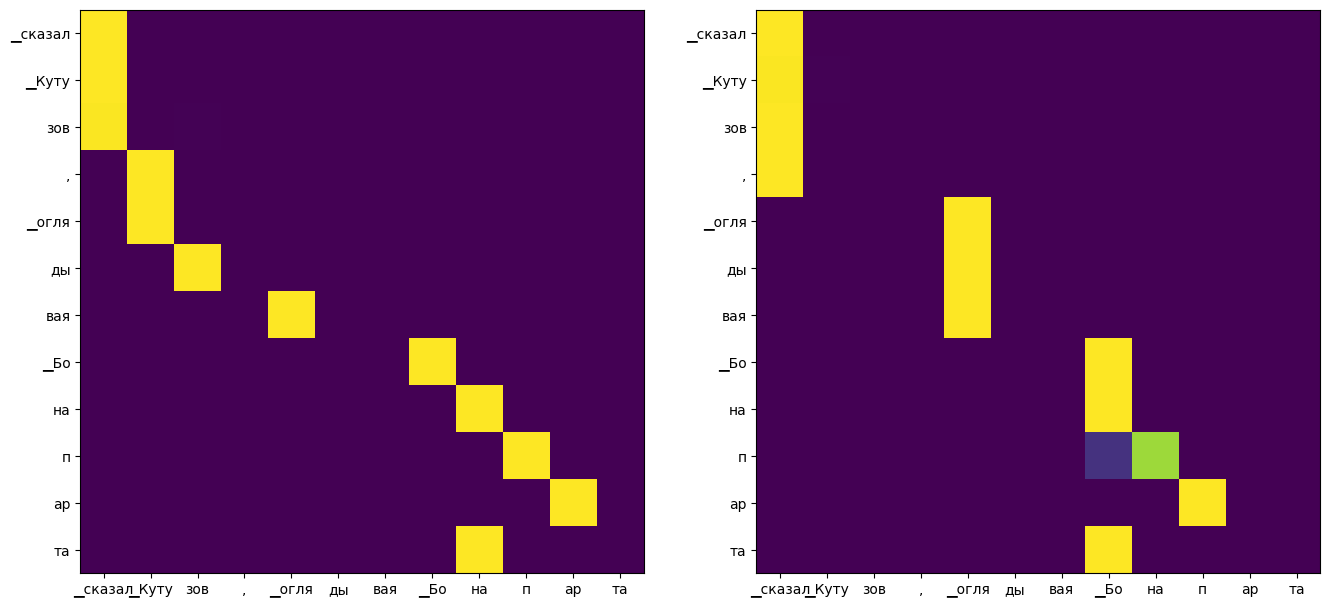

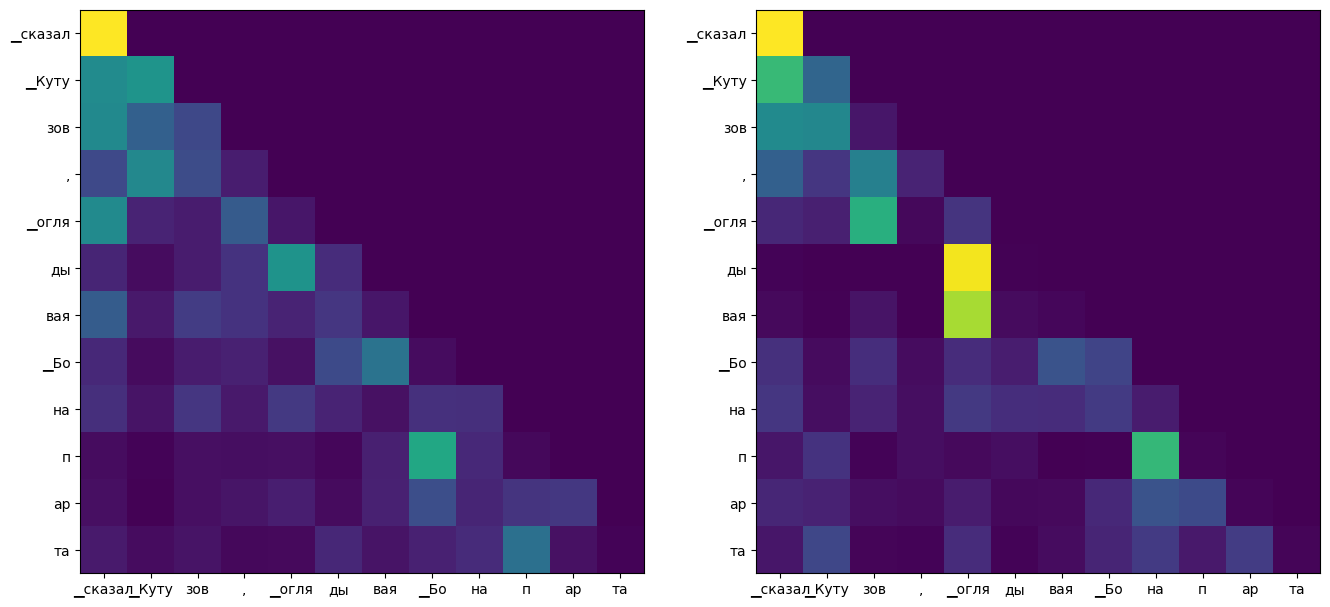

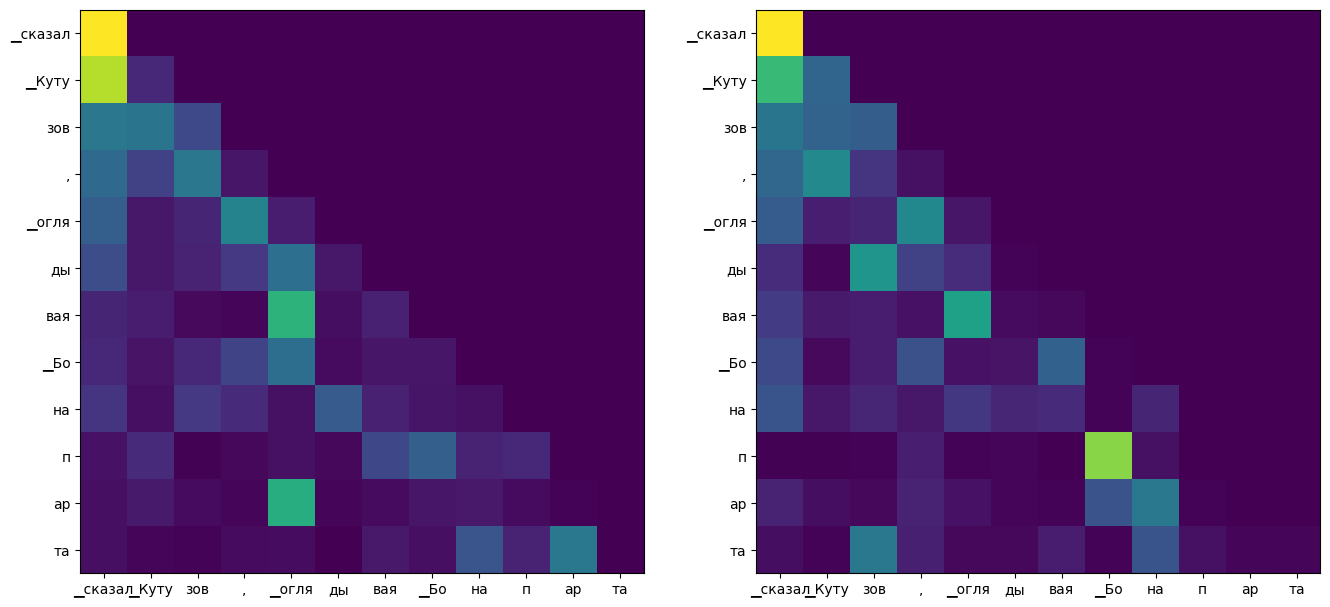

In [58]:
plot_attention_maps(my_transf_model, 'сказал Кутузов, оглядывая Бонапарта', tokenizer)